In [1]:
# CS 8803 Efficient Machine Learning
# Tanush Chopra
# GT ID: 903785867
# Date: 05/24/2025

# Lab 01: Pruning

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn.utils import prune
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import copy

# [40%] Task 01: Basic Pruning Techniques and Observations

In this section, we will explore neural network pruning using PyTorch to understand how removing parameters affects model performance and efficiency. Pruning is a model compression technique that removes unnecessary weights or neurons from trained neural networks while attempting to maintain accuracy. We will use [PyTorch's pruning library](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) to implement various pruning strategies.

## What is Pruning?

Neural network pruning systematically removes weights, neurons, or entire layers from a trained model to reduce computational complexity and memory requirements. The key insight is that many neural networks are over-parameterized, containing redundant connections that can be eliminated without significantly impacting performance.

This section is worth **40%** of the total lab grade.

---

## Task Overview

Complete the following tasks in order:

1. **Download and visualize a dataset** - Load and explore the dataset characteristics
2. **Train a model from scratch** - Implement and train a baseline neural network
3. **Evaluate the baseline model** - Measure accuracy, model size, and inference time
4. **Apply pruning techniques** - Implement magnitude-based pruning with different sparsity levels
5. **Analyze pruning sensitivity** - Visualize how different layers respond to pruning
6. **Compare performance trade-offs** - Document accuracy vs. compression relationships
7. **Reflection and analysis** - Explain your observations and lessons learned

**Deliverables:** Code implementation, visualization plots, performance analysis, and written explanations for each task.

### [5%] Part a: Download the dataset and view an image.
Using torch vision, download the CIFAR10 dataset into the Google Colab.
Create a train and test set. In torchvision you can do this by doing:

```
torchvision.datasets.DATASET(root='./data',train=[true/false],download=True)
```
You do not need to add transformations.

Then, write a function to show an image from each class. The final result should look something like this:

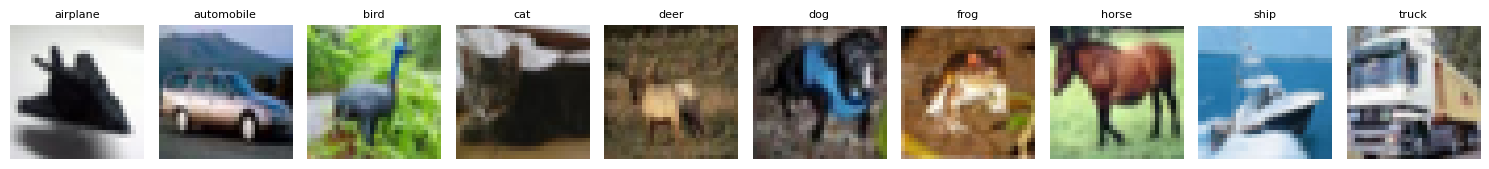


In [3]:
BATCH = 64

In [4]:
train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH, shuffle=True)

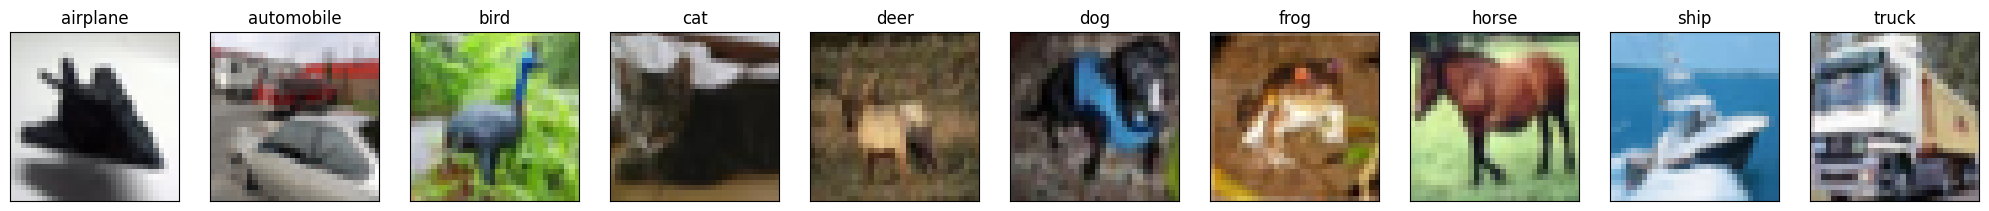

In [13]:
def show_one_image_per_class(dataset):
    labels = set(range(10))
    samples = {}
    i = -1
    while i < len(dataset) and len(labels) > 0:
        X, y = dataset[i]
        i += 1
        if y not in labels:
            continue
        X = X.permute(1, 2, 0).cpu().numpy()
        samples[y] = X
        labels.remove(y)
    fig, axes = plt.subplots(1, 10, figsize=(20, 2), constrained_layout=True)
    axes = axes.flatten()
    for y in sorted(samples.keys()):
        X = samples[y]
        axes[y].imshow(X)
        axes[y].set_title(dataset.classes[y], fontsize=12)
        axes[y].set_xticks([])
        axes[y].set_yticks([])
    plt.show()

show_one_image_per_class(train_set)

### [10%] Part b: Train a Neural Network, Count Parameters, and Evaluate

#### [5%] Training a ResNet Model for CIFAR-10

Using the provided network definition below, create a ResNet architecture configured for the CIFAR-10 dataset. You will need to:

1. **Configure the model architecture**:
  - Set the number of input channels to match CIFAR-10 images (3 RGB channels)
  - Set the number of output classes to match CIFAR-10 labels (10 classes)

2. **Train the model**:
  - Use the provided training code
  - Train for exactly **10 epochs**
  - Monitor training progress and loss

3. **Evaluate model performance**:
  - Test the trained model on the CIFAR-10 test set
  - Record the final accuracy

**Expected Results**: You should achieve approximately **85% accuracy**. Minor variations (±2-3%) are normal and acceptable. The goal is to understand the pruning process, not to create a state-of-the-art classifier.

#### [5%] Parameter Analysis

After training, analyze your model's structure by counting the parameters in each module:

1. **Count total parameters** in the entire model
2. **Count parameters by layer type** (convolutional layers, batch normalization, fully connected layers)
3. **Create a summary table** showing parameter distribution across the network
4. **Identify the most parameter-heavy modules**

This analysis will help you understand which parts of the network are most affected by pruning in the next section.

---

In [5]:
# Model definition, DO NOT CHANGE
# You will be training this model.

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Model definition, DO NOT CHANGE
# You will be training this model.

In [6]:
CIFAR10_CHANNELS = 3
CIFAR10_CLASSES = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
####
# Your model definition
#
# You need to finish this one.
model = ResNet9(CIFAR10_CHANNELS, CIFAR10_CLASSES)

In [22]:
# Training code for model
# Complete the training loop where it says to modify.

def train(model, train_loader, num_epochs, lr=1e-3, weight_decay=1e-4):
    model = model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            model.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        print(f"Epoch [{epoch+1:3d}] | Train Loss: {running_loss / len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

In [10]:
####
# Train the model.
#
# You need to finish this one.
train(model, train_loader, 10)

Epoch [  1] | Train Loss: 1.0721 | LR: 0.001000
Epoch [  2] | Train Loss: 0.5953 | LR: 0.001000
Epoch [  3] | Train Loss: 0.4212 | LR: 0.001000
Epoch [  4] | Train Loss: 0.3057 | LR: 0.001000
Epoch [  5] | Train Loss: 0.2098 | LR: 0.001000
Epoch [  6] | Train Loss: 0.1403 | LR: 0.001000
Epoch [  7] | Train Loss: 0.0847 | LR: 0.001000
Epoch [  8] | Train Loss: 0.0925 | LR: 0.001000
Epoch [  9] | Train Loss: 0.0650 | LR: 0.001000
Epoch [ 10] | Train Loss: 0.0470 | LR: 0.001000


In [17]:
####
# Evaluate the model.
#
# You need to finish this one.

def evaluate_test(model, dataloader):
    
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    
    running_loss = 0.0
    running_accuracy = 0
    model.eval()
    for i, (X, y) in enumerate(dataloader):
        with torch.no_grad():
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_hat = model(X)
            running_loss += criterion(y_hat, y).item()
            predicted = torch.argmax(y_hat, dim=1, keepdim=True)
            running_accuracy += predicted.eq(y.view_as(predicted)).sum().item()

    running_loss /= len(dataloader.dataset)
    running_accuracy /= len(dataloader.dataset)
    
    return running_loss, running_accuracy

test_loss, test_acc = evaluate_test(model, test_loader)

In [12]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.010446282094717025
Test Accuracy: 0.8371


In [13]:
torch.save(model.state_dict(), 'model.pth')

In [7]:
model = ResNet9(CIFAR10_CHANNELS, CIFAR10_CLASSES)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [8]:
####
# Count total parameters.
#
# You need to finish this.

def count_params(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_params(model)

In [9]:
print(f"Total Parameters: {total_params}")

Total Parameters: 6575370


In [10]:
####
# Count module specific parameters
# print the list of modules by parameter count
# res2.0.0 and res2.1.0 should be highest
# use module.named_modules, numel(), and module.parameters
# should get something like:
# [('res2.0.0', 2359808),
#  ('res2.1.0', 2359808),
#  ('conv4.0', 1180160),
#  ('conv3.0', 295168),
#  ('res1.0.0', 147584),
#  ('res1.1.0', 147584),
#  ('conv2.0', 73856),
#  ('classifier.2', 5130),
#  ('conv1.0', 1792),
#  ('conv4.1', 1024),
#  ('res2.0.1', 1024),
#  ('res2.1.1', 1024),
#  ('conv3.1', 512),
#  ('conv2.1', 256),
#  ('res1.0.1', 256),
#  ('res1.1.1', 256),
#  ('conv1.1', 128)]
#
# you need to finish this

def count_parameters_by_module(model):
    module_param_counts = []
    for name, module in model.named_modules():
        count = sum(p.numel() for p in module.parameters(recurse=False))
        if count <= 0:
            continue
        module_param_counts.append((name, count))
    module_param_counts.sort(key=lambda x: (x[1]), reverse=True)
    return module_param_counts

In [11]:
def count_parameters_by_layer(model):
    counts = defaultdict(int)
    for module in model.modules():
        count = sum(p.numel() for p in module.parameters(recurse=False))
        if count <= 0:
            continue
        counts[module.__class__.__name__] += count
    return counts

In [12]:
layer_counts = count_parameters_by_layer(model)
df_layers = pd.DataFrame([{"LayerType": k, "Params": v} for k, v in layer_counts.items()])
df_layers = df_layers.sort_values("Params", ascending=False).reset_index(drop=True)
df_layers["Percent"] = (df_layers["Params"] / df_layers["Params"].sum() * 100).round(2)

In [13]:
module_counts = count_parameters_by_module(model)
df_modules = pd.DataFrame(module_counts, columns=["Module", "Params"])
df_modules = df_modules.sort_values("Params", ascending=False).reset_index(drop=True)
df_modules["Percent"] = (df_modules["Params"] / df_modules["Params"].sum() * 100).round(2)

In [14]:
print("Layers:")
display(df_layers)

print("Modules:")
display(df_modules.head(16))

Layers:


,LayerType,Params,Percent
0,Conv2d,6565760,99.85
1,Linear,5130,0.08
2,BatchNorm2d,4480,0.07


Modules:


,Module,Params,Percent
0,res2.0.0,2359808,35.89
1,res2.1.0,2359808,35.89
2,conv4.0,1180160,17.95
3,conv3.0,295168,4.49
4,res1.0.0,147584,2.24
5,res1.1.0,147584,2.24
6,conv2.0,73856,1.12
7,classifier.2,5130,0.08
8,conv1.0,1792,0.03
9,conv4.1,1024,0.02


**Most parameter heavy modules based on the above is res2.0.0 and res2.1.0**

### [15%] Part c: Prune the Network and Analyze Sensitivities

#### [7.5%] Structured Pruning and Sensitivity Analysis

Implement structured pruning to systematically remove components from your trained ResNet model and analyze the impact on performance:

1. **Apply L_n structured pruning**:
  - Use PyTorch's structured pruning methods to remove entire modules
  - Target different modules of the network (convolutional layers, residual blocks, etc.)
  - Apply varying pruning ratios (10%,20%,30%,40%,50%) to each module type

2. **Evaluate pruning sensitivity**:
  - Use your existing evaluation code to test accuracy after pruning each module
  - Create a sensitivity analysis showing which modules are most/least critical
  - Document how accuracy degrades with increasing pruning ratios

3. **Generate visualizations**:
  - Plot accuracy vs. pruning ratio for different module types
  - Create a sensitivity ranking of network modules
  - Show the trade-off between compression and performance

**Expected Outcome**: You should observe that different modules have varying sensitivity to pruning, with some layers being more robust to parameter removal than others.

#### [7.5%] Parameter Reduction Analysis

For each pruning experiment above, quantify the compression achieved:

1. **Count pruned parameters**:
  - Calculate the exact number of parameters removed in each pruning step
  - Track cumulative parameter reduction across experiments

2. **Calculate compression metrics**:
  - Compute compression ratio (original params / remaining params)
  - Calculate sparsity percentage for each module
  - Document memory savings achieved

3. **Create summary tables**:
  - Show parameter counts before and after pruning for each module
  - Display compression ratios alongside accuracy metrics
  - Highlight the most efficient pruning strategies (best accuracy-to-compression trade-offs)

This analysis will demonstrate the practical benefits of pruning while quantifying the performance costs.

---

In [28]:
def prune_layer(model, layer, amount):
    
    params_before = sum(p.count_nonzero().item() for p in model.parameters())
    
    for module in model.modules():
        if not isinstance(module, layer):
            continue
        prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
        prune.remove(module, "weight")
    
    params_after = sum(p.count_nonzero().item() for p in model.parameters())
        
    _, acc = evaluate_test(model, test_loader)
    
    return {
        'accuracy': acc,
        'params_before': params_before,
        'params_after': params_after,
    }


def prune_layers(model, amounts=(0.1, 0.2, 0.3, 0.4, 0.5), layer_types=(nn.Conv2d, nn.Linear)):
    base_state = copy.deepcopy(model.state_dict())
    results = []
    for layer in layer_types:
        for amt in amounts:
            m = copy.deepcopy(model)
            m.load_state_dict(base_state)
            metrics = prune_layer(m, layer, amt)
            results.append({
                "LayerType": layer.__name__,
                "Amount": float(amt),
                "Accuracy": float(metrics["accuracy"]),
                "Parameters_Before": metrics["params_before"],
                "Parameters_After": metrics["params_after"],
                "Reduction": metrics["params_before"] - metrics["params_after"],
                "Compression": metrics["params_before"] / metrics["params_after"] if metrics["params_after"] > 0 else 0,
            })
    df = pd.DataFrame(results)
    return df

In [29]:
df_pl = prune_layers(model)

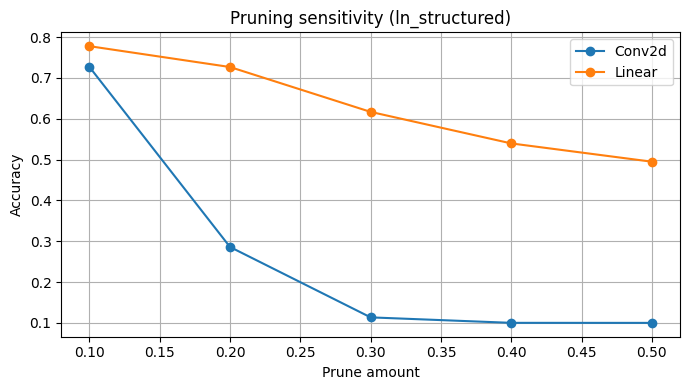

In [26]:
plt.figure(figsize=(7, 4))
for lt in df_pl["LayerType"].unique():
    sub = df_pl[df_pl["LayerType"] == lt].sort_values("Amount")
    plt.plot(sub["Amount"], sub["Accuracy"], marker="o", label=lt)
plt.xlabel("Prune amount")
plt.ylabel("Accuracy")
plt.title("Pruning sensitivity (ln_structured)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [30]:
display(df_pl)

,LayerType,Amount,Accuracy,Parameters_Before,Parameters_After,Reduction,Compression
0,Conv2d,0.1,0.7270,6575370,5920296,655074,1.110649
1,Conv2d,0.2,0.2859,6575370,5266347,1309023,1.248564
2,Conv2d,0.3,0.1135,6575370,4602633,1972737,1.428611
3,Conv2d,0.4,0.1001,6575370,3948684,2626686,1.665205
4,Conv2d,0.5,0.1000,6575370,3293610,3281760,1.996402
5,Linear,0.1,0.7778,6575370,6574858,512,1.000078
6,Linear,0.2,0.7267,6575370,6574346,1024,1.000156
7,Linear,0.3,0.6168,6575370,6573834,1536,1.000234
8,Linear,0.4,0.5396,6575370,6573322,2048,1.000312
9,Linear,0.5,0.4948,6575370,6572810,2560,1.000389


Pruning convolutional layers provides meaningful compression, but accuracy quickly collapses beyond 10%, making light pruning the best balance point. Pruning the final linear layer barely reduces model size since it holds very few parameters, yet it still hurts accuracy as pruning increases. Overall, the best accuracy-to-compression trade-off is achieved with ~10% Conv2d pruning, while linear pruning is largely ineffective for compression.

In [31]:
def prune_module(model, module, amount):
    params_before = sum(p.count_nonzero().item() for p in model.parameters())
    prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
    prune.remove(module, "weight")
    params_after = sum(p.count_nonzero().item() for p in model.parameters())
    _, acc = evaluate_test(model, test_loader)
    return {
        'accuracy': acc,
        'params_before': params_before,
        'params_after': params_after,
    }

def prune_modules(model, module_names, amounts=(0.1, 0.2, 0.3, 0.4, 0.5)):
    base_state = copy.deepcopy(model.state_dict())
    results = []
    for name in module_names:
        for amt in amounts:
            m = copy.deepcopy(model)
            m.load_state_dict(base_state)
            module = m.get_submodule(name)
            if isinstance(module, nn.BatchNorm2d):
                continue
            metrics = prune_module(m, module, amt)
            results.append({
                "ModuleName": name,
                "Amount": float(amt),
                "Accuracy": float(metrics["accuracy"]),
                "Parameters_Before": metrics["params_before"],
                "Parameters_After": metrics["params_after"],
                "Reduction": metrics["params_before"] - metrics["params_after"],
                "Compression": metrics["params_before"] / metrics["params_after"] if metrics["params_after"] > 0 else 0,
            })
    df = pd.DataFrame(results)
    return df

In [32]:
df_pm = prune_modules(model, module_names=list(df_modules["Module"]))

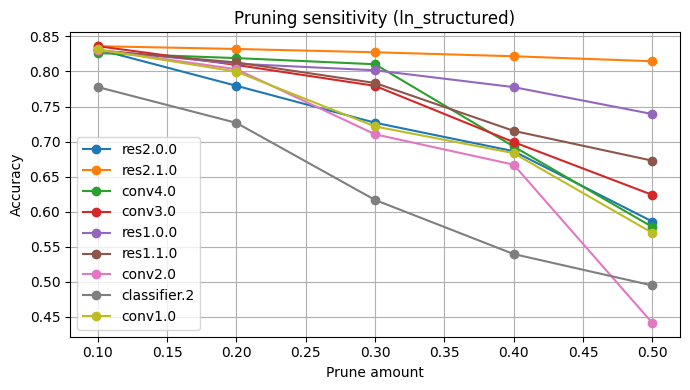

In [33]:
plt.figure(figsize=(7, 4))
for lt in df_pm["ModuleName"].unique():
    sub = df_pm[df_pm["ModuleName"] == lt].sort_values("Amount")
    plt.plot(sub["Amount"], sub["Accuracy"], marker="o", label=lt)
plt.xlabel("Prune amount")
plt.ylabel("Accuracy")
plt.title("Pruning sensitivity (ln_structured)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [34]:
display((df_pm))

,ModuleName,Amount,Accuracy,Parameters_Before,Parameters_After,Reduction,Compression
0,res2.0.0,0.1,0.8316,6575370,6340362,235008,1.037065
1,res2.0.0,0.2,0.7796,6575370,6105354,470016,1.076984
2,res2.0.0,0.3,0.7269,6575370,5865738,709632,1.120979
3,res2.0.0,0.4,0.6863,6575370,5630730,944640,1.167765
4,res2.0.0,0.5,0.5860,6575370,5395722,1179648,1.218627
5,res2.1.0,0.1,0.8361,6575370,6340362,235008,1.037065
6,res2.1.0,0.2,0.8321,6575370,6105354,470016,1.076984
7,res2.1.0,0.3,0.8274,6575370,5865738,709632,1.120979
8,res2.1.0,0.4,0.8217,6575370,5630730,944640,1.167765
9,res2.1.0,0.5,0.8146,6575370,5395722,1179648,1.218627


Pruning early blocks such as res2.0.0 and res2.1.0 gives meaningful compression (up to ~1.22×) while maintaining relatively high accuracy (>0.81) even at 50%, making them strong candidates for structured pruning. Deeper convolutional modules like conv4.0 and conv3.0 show sharper accuracy drops once pruning exceeds 20–30%, suggesting they are more sensitive and should only be pruned lightly. By contrast, very small layers (e.g., classifier.2, conv1.0, conv2.0, res1.x) contribute negligible compression despite pruning, so targeting them is ineffective for model size reduction and mainly harms accuracy.

### [10%] Part d: Explaining Pruning

#### [5%] Pruning Sensitivity Analysis and Hypothesis

Based on your module-wise pruning experiments and results, analyze the patterns you observed:

**Note:** You should conduct pruning sensitivity experiments across different **module types** (e.g., MLP blocks, residual connections).

Use your findings to support the following analyses:

1. **Module Robustness Hypothesis**:
   - Examine your pruning sensitivity graphs for different **module types**.
   - Identify which modules were most or least robust to pruning.
   - Hypothesize why certain modules tolerate more pruning (e.g., feature complexity, redundancy, gradient flow, or functional role).

2. **Progressive Pruning Trends**:
   - Describe how sensitivity patterns change with increasing pruning ratios.
   - Identify any non-linear trends or abrupt drops in performance.
   - Interpret these effects in terms of capacity, redundancy, or structural importance.

3. **Module-Specific Observations**:
   - Highlight differences in pruning sensitivity across module types.
   - Discuss how components like residual connections influence pruning robustness.
   - Comment on any notable behavior of auxiliary modules such as normalization layers.

**[Answer]:** 

1. Module Robustness Hypothesis

From the experiments, mid-level residual blocks such as res2.0.0 and res2.1.0 showed high robustness: even at 50% pruning they maintained >0.81 accuracy, suggesting significant feature redundancy and strong gradient flow within these blocks. By contrast, deeper convolutional layers like conv4.0 and conv3.0 were far less robust, losing accuracy rapidly after ~20–30% pruning, which likely reflects their role in encoding more task-specific, high-level features with less redundancy. Small modules such as the classifier and early conv layers contributed little to compression but caused accuracy drops, implying they are capacity bottlenecks that cannot be heavily pruned.

2. Progressive Pruning Trends

Across modules, pruning sensitivity generally followed a nonlinear pattern: modest pruning (10–20%) caused small accuracy losses or even stable performance, while beyond ~30% there were abrupt drops, especially in conv3/conv4 layers. This suggests that networks have an initial zone of redundant parameters that can be safely removed, but pruning past that threshold begins to cut into essential representational capacity. The stability in residual blocks at higher ratios supports the idea that skip connections help preserve information flow even under aggressive pruning.

3. Module-Specific Observations

Residual blocks clearly demonstrated higher tolerance to pruning, consistent with the hypothesis that skip connections buffer representational loss by providing alternative signal pathways. Convolutional layers deeper in the network showed strong sensitivity, reflecting their central role in consolidating discriminative features. Auxiliary modules like BatchNorm (implicit in these blocks) likely improved robustness indirectly by rescaling activations, but pruning their associated channels still degrades stability once redundancy is exhausted.


---

#### [5%] Alternative Pruning Metrics

While this exercise used L2 norm for pruning decisions, many other importance metrics exist. List **5 creative pruning metrics** beyond simple L_p norms:

**Reference**: You may explore the [Torch Pruning library](https://github.com/VainF/Torch-Pruning) documentation for inspiration, but provide original explanations.

**Required Format**: For each metric, provide:
- Metric name and brief description
- Intuition for why it might be effective
- Potential advantages/disadvantages

**Example Metrics to Explore:**
- Gradient-based importance measures
- Activation-based metrics
- Information-theoretic approaches
- Network connectivity measures
- Task-specific importance scores

**[Refer to the final markdown cell for my answer]**

---

#### [2%] Bonus: Pruning vs. Quantization Trade-offs

Both pruning and quantization reduce model size, but through different mechanisms. Analyze when each approach is preferable:

**Required Analysis:**

1. **When Pruning is Better**:
  - Identify scenarios where removing parameters entirely is more beneficial than reducing precision
  - Consider hardware constraints, inference patterns, and model architectures
  - Discuss memory vs. computational trade-offs

2. **When Quantization is Better**:
  - Explain situations where reducing bit precision is more effective than removing parameters
  - Consider deployment constraints and hardware acceleration
  - Discuss preservation of model capacity vs. efficiency gains

3. **Hybrid Approaches**:
  - Describe scenarios where combining both techniques might be optimal
  - Consider the order of application (prune-then-quantize vs. quantize-then-prune)

**Note**: There is no single correct answer. Provide thoughtful analysis based on different use cases, hardware constraints, and performance requirements.

---

### Alternative Pruning Metrics

#### 1. Gradient-Flow Preservation (GraSP)
GraSP scores weights by estimating how their removal would disrupt gradient flow using a Hessian–gradient product. The intuition is that good trainability requires strong gradient propagation, so parameters critical for this should be preserved. This approach works even at initialization, identifying subnetworks that remain trainable. The advantage is that it does not require full training, saving compute compared to prune–retrain cycles. The main disadvantage is that Hessian-based computations are heavier than simple magnitude-based pruning.

#### 2. Synaptic-Flow Score (SynFlow)
SynFlow computes a data-free importance score by backpropagating through a linearized version of the network, using absolute weights and constant input signals. This ensures that pruning preserves overall “synaptic flow” and avoids collapsing entire layers. The intuition is that a balanced flow of signals through the network is crucial for representational capacity. The major advantage is that it works without data and prevents layer collapse. Its weakness is that it does not consider the actual task or labels, meaning some unhelpful neurons may still be preserved.

#### 3. Fisher Loss-Impact
The Fisher loss-impact metric estimates the expected increase in loss if a neuron or filter is removed. First-order versions use gradients multiplied by activations, while second-order versions approximate curvature with the Fisher information or Hessian. The idea is that if removing a component barely changes the loss, it is expendable. The benefit is its strong task-awareness and theoretical foundation. The downside is that second-order methods can be computationally expensive, while first-order approximations can be noisy.

#### 4. Activation-Rank (HRank)
HRank analyzes the rank of activation matrices for each filter across a dataset. Filters producing low-rank, redundant, or near-constant activations are pruned since they contribute less diverse information. The intuition is that high-rank activations capture richer features, while low-rank activations reflect redundancy. Advantages include structured pruning at the filter level and explicit redundancy removal. The disadvantage is that it requires dataset passes and costly decompositions, and it may underestimate rare but important features.

#### 5. Scale-and-Movement Score
Scale-and-Movement combines the magnitude of BatchNorm scaling factors and how weights consistently move toward or away from zero during training or fine-tuning. The idea is that the network itself “decides” which channels are unimportant by shrinking them. This approach is especially effective for transfer learning scenarios with pretrained models. The advantages are its simplicity and natural support for structured pruning. However, it relies on BatchNorm layers and requires monitoring training dynamics, which adds complexity.